In [84]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
df = pd.read_csv("/Users/sujitharajan/Documents/GitHub/IS460/data/df_prepared.csv")


In [86]:
df.drop(columns=df.columns[0], axis = 1, inplace =True)
df.head()



,source_city,departure_time,stops,arrival_time,destination_city,class,days_left_binned,duration_sqrt,price
0,-1.732372,0.198274,-2.4911,0.236474,0.37094,-0.674351,2.375914,-1.742522,5953.0
1,-1.732372,-0.298600,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5953.0
2,-1.732372,-0.298600,-2.4911,-2.002790,0.37094,-0.674351,2.375914,-1.742522,5956.0
3,-1.732372,0.469739,-2.4911,-0.820969,0.37094,-0.674351,2.375914,-1.717006,5955.0
4,-1.732372,0.469739,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5955.0


In [3]:
df['log_price'] = np.log(df['price'])

In [4]:
X = np.array(df.drop('price', axis=1))
y = np.array(df['log_price'])
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



In [5]:
def create_lstm_model(input_shape):
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LS2TM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [14]:
#k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)
r_squared_values = []
adjusted_r_squared_values = []
mse_score = []
rmse_score = []
mape_score = []
fold_no = 1
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Reshape the input for LSTM
    X_train_fold = np.reshape(X_train_fold, (X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_test_fold = np.reshape(X_test_fold, (X_test_fold.shape[0], X_test_fold.shape[1], 1))
    
    # Create LSTM model
    model = create_lstm_model((X_train_fold.shape[1], 1))
    
    # Fit the model
    print(f'Training for fold {fold_no} ...')
    model.fit(X_train_fold, y_train_fold, epochs=130, batch_size=32)
    
    # Evaluate the model
    y_pred = model.predict(X_test_fold)
    
    # Calculate R-squared for this fold
    r2 = r2_score(np.exp(y_test_fold), np.exp(y_pred))
    r_squared_values.append(r2)
    
    # Calculate the Adjusted R-squared for this fold
    n = len(y_test_fold)  # number of observations in the fold
    p = X_train_fold.shape[2]  # number of predictors used in the model
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    adjusted_r_squared_values.append(adjusted_r2)
    mse = mean_squared_error(np.exp(y_test_fold), np.exp(y_pred))
    mse_score.append(mse)
    rmse = np.sqrt(mse)
    rmse_score.append(rmse)
    mape = mean_absolute_percentage_error(np.exp(y_test_fold), np.exp(y_pred))
    mape_score.append(mape)
    # Print the R-squared and Adjusted R-squared values
    print(f'Fold {fold_no}: R-squared = {r2}, Adjusted R-squared = {adjusted_r2}, MSE = {mse}, RMSE = {rmse}, MAPE = {mape}')
    
    fold_no += 1



Training for fold 1 ...
Epoch 1/130


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7393/7393 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 2.2711
Epoch 2/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 0.3399
Epoch 3/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.1928
Epoch 4/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0982
Epoch 5/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0461
Epoch 6/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 0.0279
Epoch 7/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0208
Epoch 8/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0170
Epoch 9/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0146
Epoch 10/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0136
Epoch 11/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0126
Epoch 12/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0119
Epoch 13/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 0.0114
Epoch 14/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 0.0111
Epoch 15/130


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7393/7393 ━━━━━━━━━━━━━━━━━━━━ 182s 24ms/step - loss: 2.3878
Epoch 2/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.3341
Epoch 3/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.1962
Epoch 4/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.1007
Epoch 5/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0450
Epoch 6/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 258s 35ms/step - loss: 0.0247
Epoch 7/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0187
Epoch 8/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0161
Epoch 9/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0144
Epoch 10/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0136
Epoch 11/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0130
Epoch 12/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0126
Epoch 13/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0123
Epoch 14/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0119
Epoch 15/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7393/7393 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 2.3350
Epoch 2/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - loss: 0.3322
Epoch 3/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 337s 46ms/step - loss: 0.1928
Epoch 4/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 134s 18ms/step - loss: 0.0968
Epoch 5/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 792s 107ms/step - loss: 0.0430
Epoch 6/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0258
Epoch 7/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0189
Epoch 8/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0157
Epoch 9/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 0.0136
Epoch 10/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 0.0124
Epoch 11/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0115
Epoch 12/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - loss: 0.0111
Epoch 13/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - loss: 0.0106
Epoch 14/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 0.0104
Epoch 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7393/7393 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 2.3607
Epoch 2/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.3383
Epoch 3/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 0.1959
Epoch 4/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0995
Epoch 5/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0480
Epoch 6/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0284
Epoch 7/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0199
Epoch 8/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - loss: 0.0158
Epoch 9/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0138
Epoch 10/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0127
Epoch 11/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0121
Epoch 12/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0116
Epoch 13/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0113
Epoch 14/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0111
Epoch 15/130


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7393/7393 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 2.3870
Epoch 2/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 0.3286
Epoch 3/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.1919
Epoch 4/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0966
Epoch 5/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0445
Epoch 6/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0255
Epoch 7/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0184
Epoch 8/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0153
Epoch 9/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - loss: 0.0137
Epoch 10/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0129
Epoch 11/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0122
Epoch 12/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0118
Epoch 13/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 0.0113
Epoch 14/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0111
Epoch 15/130


In [16]:

a = sum(r_squared_values)/len(r_squared_values)
b = sum(adjusted_r_squared_values)/len(adjusted_r_squared_values)
c = sum(mse_score)/len(mse_score)
d = sum(rmse_score)/len(rmse_score)
e = sum(mape_score)/len(mape_score)
lstm_results = pd.DataFrame(['LSTM', c, a, e, b, d ]).transpose()
lstm_results.columns = ['Method', 'MSE', 'R2', 'MAPE','Adjusted R2', 'RMSE']
lstm_results

,Method,MSE,R2,MAPE,Adjusted R2,RMSE
0,LSTM,6165668.725532,0.987943,0.141253,0.987943,2440.419936


In [ ]:
# Fitting the RNN to the Training set
# model.fit(X_train, y_train, epochs = 130, batch_size = 32)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
predicted_price

1849/1849 [==============================] - 4s 2ms/step


array([[ 9.536197 ],
       [ 8.969202 ],
       [10.820649 ],
       ...,
       [ 8.902681 ],
       [ 7.8842287],
       [ 9.079265 ]], dtype=float32)

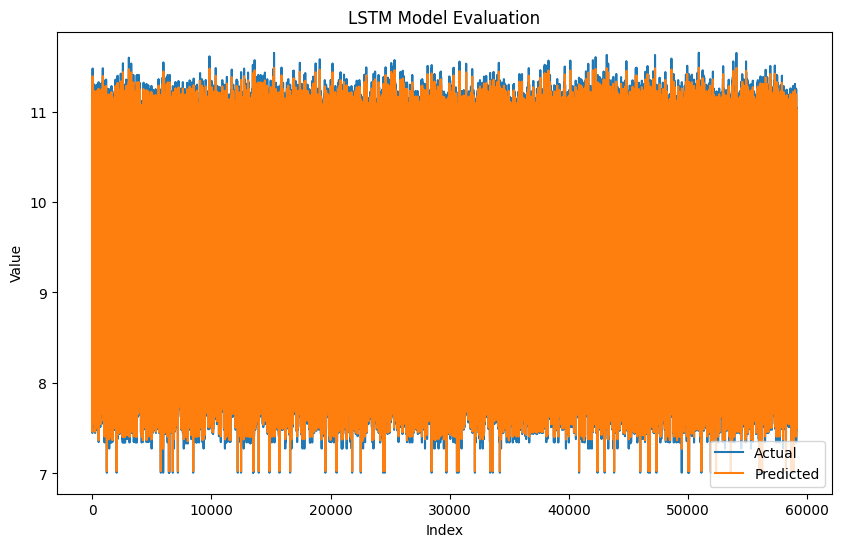

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predicted_price, label='Predicted')
plt.xlabel('Index')  # Use index as the x-axis label
plt.ylabel('Value')
plt.title('LSTM Model Evaluation')
plt.legend()
plt.show()

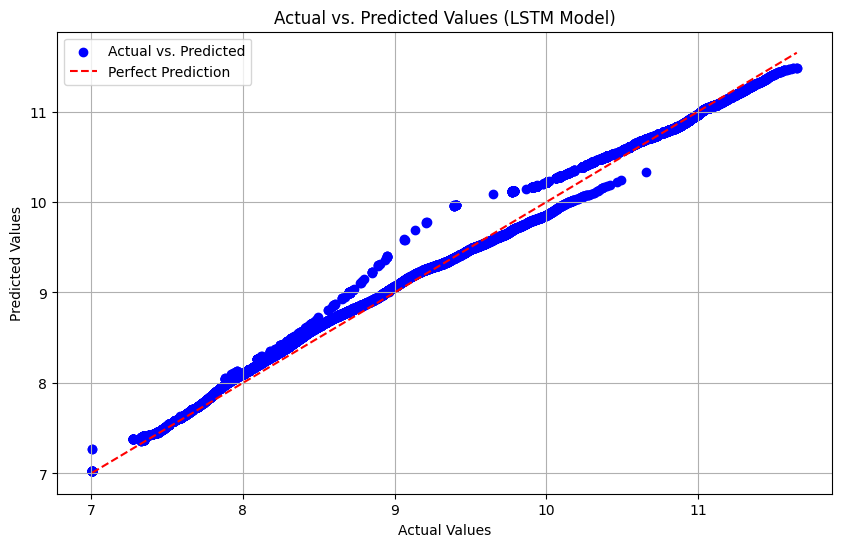

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_price, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (LSTM Model)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
mse = mean_squared_error(np.exp(y_test), np.exp(predicted_price))
r2 = r2_score(np.exp(y_test), np.exp(predicted_price))
mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(predicted_price))
n = len(y_test) 
p = X_test.shape[1] 
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
rmse = np.sqrt(mse)



In [ ]:
lstm_results = pd.DataFrame(['LSTM', mse, r2, mape, adjusted_r2, rmse ]).transpose()
lstm_results.columns = ['Method', 'MSE', 'R2', 'MAPE','Adjusted R2', 'RMSE']
lstm_results

,Method,MSE,R2,MAPE,Adjusted R2,RMSE
0,LSTM,2313244.390792,0.995517,0.075533,0.995516,1520.935367


In [ ]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score, KFold

# # Function to create the model, required for KerasRegressor
# def create_model():
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     # Adding a third LSTM layer and some Dropout regularisation
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     # Adding a fourth LS2TM layer and some Dropout regularisation
#     model.add(LSTM(units = 50))
#     model.add(Dropout(0.2))
#     # Adding the output layer
#     model.add(Dense(units = 1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Wrap the Keras model with KerasRegressor
# model = KerasRegressor(build_fn=create_model, epochs=130, batch_size=32, verbose=0)

# # Define the K-fold cross-validator
# kfold = KFold(n_splits=5, shuffle=False)  # Set shuffle=False for time series data

# # Perform cross-validation and get scores
# results = cross_val_score(model, np.array(X), np.array(y), cv=kfold, scoring='neg_mean_squared_error')

# # Convert the scores to positive values (since 'neg_mean_squared_error' returns negative values)
# mse_scores = -results

# print("Cross-validated MSE scores: ", mse_scores)
# print("Mean MSE: ", mse_scores.mean())
# print("Standard deviation of MSE: ", mse_scores.std())


In [ ]:
# import numpy as np
# from keras.models import load_model


# model = load_model('your_lstm_model.h5')

# # Define a function to collect user input
# def get_user_input():
#     # Initialize an empty list to store user inputs
#     user_input = []
#     # List all the inputs the user needs to provide
#     input_features = [
#         'airline',
#         'source_city',
#         'departure_time',
#         'stops',
#         'arrival_time',
#         'destination_city',
#         'class',
#         'days_left_binned',
#         'duration_sqrt'
#     ]
#     # Ask user for each input
#     for feature in input_features:
#         value = float(input(f"Enter {feature}: "))
#         user_input.append(value)
#     return np.array(user_input)

# # Collect user input
# user_input = get_user_input()

# # Assuming that the input should be normalized or scaled as per the model's training
# # You should replace this with the actual preprocessing used during training
# # For example:
# # from sklearn.preprocessing import MinMaxScaler
# # scaler = MinMaxScaler()
# # user_input_scaled = scaler.transform([user_input])  # Assuming scaler is pre-fitted

# # Reshape the input to match LSTM expected input shape [samples, time steps, features]
# # Assuming a time step of 1 for a single prediction
# user_input_reshaped = user_input.reshape(1, 1, -1)

# # Predict the price using the LSTM model
# predicted_price = model.predict(user_input_reshaped)

# # Output the predicted price
# print(f"The predicted price is: {predicted_price[0][0]}")


In [7]:
model = create_lstm_model(X_train)
model.fit(X_train, y_train, epochs=130, batch_size=32)

Epoch 1/130


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7393/7393 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 2.4863
Epoch 2/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.3393
Epoch 3/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.1964
Epoch 4/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.1002
Epoch 5/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0466
Epoch 6/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0255
Epoch 7/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - loss: 0.0177
Epoch 8/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0145
Epoch 9/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0128
Epoch 10/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0120
Epoch 11/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0116
Epoch 12/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0111
Epoch 13/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0108
Epoch 14/130
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 0.0105
Epoch 15/130


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295689 entries, 0 to 295688
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           295689 non-null  float64
 1   source_city       295689 non-null  float64
 2   departure_time    295689 non-null  float64
 3   stops             295689 non-null  float64
 4   arrival_time      295689 non-null  float64
 5   destination_city  295689 non-null  float64
 6   class             295689 non-null  float64
 7   days_left_binned  295689 non-null  float64
 8   duration_sqrt     295689 non-null  float64
 9   price             295689 non-null  float64
 10  log_price         295689 non-null  float64
dtypes: float64(11)
memory usage: 24.8 MB


In [162]:
columns = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 
           'destination_city', 'class', 'days_left_binned', 'duration_sqrt']
column = ['Airline', 'Source City', 'Departure Time', 'Stops', 'Arrival Time', 
           'Destination city', 'Class', 'Duration', 'Days Left']
input_data = []
for column in column:
    user_input = input(f"Enter {column}: ")
    input_data.append(user_input)
    print(column + " inputted is " +  user_input)

columns = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 
           'destination_city', 'class', 'duration', 'days_left']
df_1 = pd.DataFrame([input_data], columns=columns)
df_1['duration'] = pd.to_numeric(df_1['duration'], errors='coerce')
df_1['days_left'] = pd.to_numeric(df_1['days_left'], errors='coerce')

import numpy as np
import pandas as pd
import category_encoders as ce
df = pd.read_csv("/Users/sujitharajan/Documents/GitHub/IS460/data/Clean_Dataset.csv")
df.drop(columns=df.columns[0], axis = 1, inplace =True)
df_1['price'] = 10838
first_part = df.iloc[:31]
second_part = df.iloc[32:]
df_1 = pd.concat([first_part, df_1, second_part], ignore_index=True)
df_1['duration_sqrt'] = np.sqrt(df_1['duration'])
bins = [0,7,14,21,28,35,42,50]
df_1['days_left_binned'] = pd.cut(df_1['days_left'], bins=bins, labels=False, right=False)
cat_cols = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'days_left_binned']

# list of categorical column
te = ce.TargetEncoder(cols=cat_cols)
df1 = te.fit_transform(df_1, df_1['price'])
df1 = df1[['airline','source_city','departure_time','stops','arrival_time','destination_city','class','days_left_binned','duration_sqrt']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df1)
df_scaled = scaler.transform(df1)
df_prepared = pd.DataFrame(df_scaled,columns=df1.columns)

df_2 = df_prepared.loc[[30]]
df2 = np.reshape(df_2, (df_2.shape[0], df_2.shape[1], 1))
predicted_price = model.predict(df2)
prices = np.exp(predicted_price)
print('The predicted price is ' , prices)


Airline inputted is Indigo
Source City inputted is Delhi
Departure Time inputted is Afternoon
Stops inputted is one
Arrival Time inputted is Evening
Destination city inputted is Mumbai
Class inputted is Economy
Duration inputted is 8.0
Days Left inputted is 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted price is  [[9480.324]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
